## Programming Lab #2
## Foundations of Machine Learning

The purpose of this project is to build predictive algorithms that predict the likelihood a person has a stroke. The data include:
  
  - `age`: Patient age, numeric
  - `avg_glucose_level`: Blood sugar levels, numeric
  - `bmi`: Body mass index, numeric
  - `ever_married`: Ever married, dummy/character (Yes, No)
  - `gender`: Male, Female, or Other, character
  - `heart_disease`: Has heart disease, dummy
  - `hypertension`: Has hypertension, dummy
  - `id`: Study identification number
  - `Residence_type`: Type of residence, dummy/character (Urban, Rural)
  - `smoking_status`: Former, never, or current smoker, categorical
  - `work_type`: Employment type (Never worked (Never_worked), homemaker ("children"), Public sector employment (Govt_job), Private sector employment (`Private`), Self-employed (`Self-employed`)
  - `stroke`: Suffered a stroke in the sample period
  
The data come in two files: `training_data.csv`, which you should use to build your models, and `testing_data.csv`, which you should use to test your models. The models must be trained on the training data and tested on the testing data, but providing both files allows you to experiment with your choices and iterate on model designs. If performance drops on the testing data, you know there's a problem.
  
You can use any of the tools presented in class: $k$ nearest neighbor, linear models, or decision trees. In principle, $k$ means clustering might also be helpful for looking for patterns in the data that the other methods might miss. Using canned versions of more advanced tools (boosting, bagging, random forests, neural networks, etc.) is deeply unsporting and thus not allowed. You can be creative about transforming variables, or combining decision trees with linear models or $k$NN. Try something interesting. Fail extravagantly. The goal is to work on an intellectually interesting question that is similar to the tasks that data scientists are called on to do every day.
  
We will compare the groups' models to see if there are common trends or significant differences, and also to declare **The Winners** on the basis of whichever team achieves the lowest $RMSE$ on the testing data. A simple linear model with some polynomials and dummy variables achieves an $R^2$ of .087 and a $RMSE$ of .206. 

In [298]:
# Initalizing a print function to limit repetition

def pn(x):
    print(x, '\n')

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_train = pd.read_csv('./data/training_data.csv')
df_test = pd.read_csv('./data/testing_data.csv')
pn(df_train.head()) # view the dataframe

gdf_train = pd.DataFrame.copy(df_train) # make df that we can edit
gdf_test = pd.DataFrame.copy(df_test) # make df that we can edit

# Look at some stats
pn(df_train.describe())  #see that bmi is the one missing values
pn(df_test.describe()) #see that bmi is the one missing values

   Unnamed: 0     id  gender   age  hypertension  heart_disease ever_married  \
0        2465  68685    Male  36.0             0              0          Yes   
1        4311  59058  Female  45.0             0              0          Yes   
2        2375  46068    Male  58.0             0              0           No   
3        5017  36837  Female  61.0             0              0          Yes   
4         753  30550  Female  78.0             0              0           No   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0       Govt_job          Urban              65.87  32.2  formerly smoked   
1       Govt_job          Rural              68.66  25.3     never smoked   
2  Self-employed          Rural             170.93  30.7          Unknown   
3  Self-employed          Urban              69.88  27.1     never smoked   
4        Private          Urban             103.86  30.6          Unknown   

   stroke  
0       0  
1       0  
2       0  
3       

In [300]:
### Data Cleaning

## cleaning smoking_status var:
#for smoking status two options: remove nulls or make unkowns as a smoker
#removing Unknown values for smoking
var = 'smoking_status'
pn(df_train[var].value_counts()) #1241 unknown values for smoking status of train, which is 30% of data 
pn(df_test[var].value_counts()) #303 unknown values for smoking status of test
gdf_train[var] = gdf_train[var].replace('Unknown', np.nan)
gdf_test[var] = gdf_test[var].replace('Unknown', np.nan)
gdf_train[var+'_NA'] = gdf_train[var].isnull()
gdf_test[var+'_NA'] = gdf_test[var].isnull()

never smoked       1505
Unknown            1241
formerly smoked     699
smokes              642
Name: smoking_status, dtype: int64 

never smoked       387
Unknown            303
formerly smoked    186
smokes             147
Name: smoking_status, dtype: int64 



In [301]:
print(pd.crosstab(df_train[var],df_train['stroke']),'\n') #cant assume anything with the stroke 
print(pd.crosstab(df_test[var],df_test['stroke']),'\n') #cant assume anything with the stroke 

print(pd.crosstab(df_train[var],df_train['work_type']),'\n') #cant assume anything with the work_type 
print(pd.crosstab(df_test[var],df_test['work_type']),'\n') #cant assume anything with the work_type

#no cross tab helping lead to any answers

stroke              0   1
smoking_status           
Unknown          1204  37
formerly smoked   645  54
never smoked     1434  71
smokes            605  37 

stroke             0   1
smoking_status          
Unknown          293  10
formerly smoked  170  16
never smoked     368  19
smokes           142   5 

work_type        Govt_job  Never_worked  Private  Self-employed  children
smoking_status                                                           
Unknown               100             7      518            129       487
formerly smoked       108             0      419            161        11
never smoked          229             8      955            271        42
smokes                 97             0      437            106         2 

work_type        Govt_job  Never_worked  Private  Self-employed  children
smoking_status                                                           
Unknown                22             1      122             27       131
formerly smoked       

In [302]:
#pick either one below and try to run in multiple ways

In [303]:
# #removing Unknown values for smoking
gdf_test=gdf_test.loc[gdf_test[var+'_NA']== 0,:]
gdf_train=gdf_train.loc[gdf_train[var+'_NA']== 0,:]

In [304]:
# #replacing unknown values as smoking as assume that people who did not awnser that question probably are smoking still
# gdf_train.loc[gdf_train[var].isnull(), var] = 'smokes' # Changing rows with nans to a new category called "not happy"
# print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # checks that nulls were renamed
# gdf_test.loc[gdf_test[var].isnull(), var] = 'smokes' # Changing rows with nans to a new category called "not happy"
# print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # checks that nulls were renamed

In [305]:
#just drop the smoking variable as 30% of data does not have values
#gdf_train = gdf_train.drop(columns=[var])
#gdf_test = gdf_test.drop(columns=[var])


In [306]:
## cleaning id var:

missing_values_train = df_train['id'].isnull().sum()
missing_values_test = df_test['id'].isnull().sum()

# print the number of missing values
print(f"Number of missing values in training set 'id' column: {missing_values_train}")
print(f"Number of missing values in training set 'id' column: {missing_values_test}")

# Check for duplicated id values
duplicated_ids_train = df_train.duplicated('id').sum()
duplicated_ids_test = df_test.duplicated('id').sum()

# If there are any duplicated IDs, 'duplicated_ids' will contain those rows
print(f"\nduplicated IDs found in training set: {duplicated_ids_train}" )
print(f"duplicated IDs found in testing set: {duplicated_ids_train}")

# id values seem clean

Number of missing values in training set 'id' column: 0
Number of missing values in training set 'id' column: 0

duplicated IDs found in training set: 0
duplicated IDs found in testing set: 0


In [307]:
## cleaning Residence_type var:

# print unique variables
print("Unique Residence_type values in training set:", df_train["Residence_type"].unique())
print("Unique Residence_type values in testing set:", df_test["Residence_type"].unique())

# Residence_type var already seems clean

Unique Residence_type values in training set: ['Urban' 'Rural']
Unique Residence_type values in testing set: ['Urban' 'Rural']


In [308]:
## cleaning work_type var:

var = 'work_type'
print(df_train[var].value_counts()) #no unknowns, they add up to 4087
print(df_test[var].value_counts()) #no unknowns, adds up to 1023
# no need to clean anything

Private          2329
Self-employed     667
children          542
Govt_job          534
Never_worked       15
Name: work_type, dtype: int64
Private          596
Self-employed    152
children         145
Govt_job         123
Never_worked       7
Name: work_type, dtype: int64


count    2846.000000
mean       48.984891
std        18.824734
min        10.000000
25%        34.000000
50%        50.000000
75%        63.000000
max        82.000000
Name: age, dtype: float64 

count    720.000000
mean      48.336111
std       19.073705
min       10.000000
25%       32.000000
50%       50.000000
75%       63.000000
max       82.000000
Name: age, dtype: float64 

Total Missings: 
 0 

Total Missings: 
 0 



<AxesSubplot:>

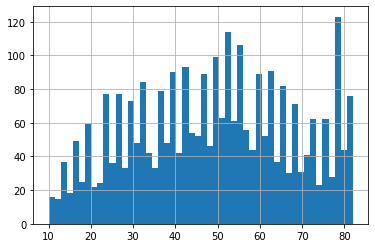

In [309]:
## cleaning age var:
var = 'age'

# Exploring missing values
pn(gdf_train[var].describe()) # looks good, numeric, ages range from 0 to 82
pn(gdf_test[var].describe()) # looks good, numeric, ages range from 0 to 82
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # confirms checks for NAs
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # confirms checks for NAs 
# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at age distribution in sample
gdf_train[var].hist(bins=50)

count    2846.000000
mean      108.810306
std        48.059458
min        55.120000
25%        77.465000
50%        92.860000
75%       116.440000
max       271.740000
Name: avg_glucose_level, dtype: float64 

count    720.000000
mean     109.660722
std       49.229437
min       55.250000
25%       77.407500
50%       91.875000
75%      118.520000
max      263.560000
Name: avg_glucose_level, dtype: float64 

Total Missings: 
 0 

Total Missings: 
 0 



<AxesSubplot:>

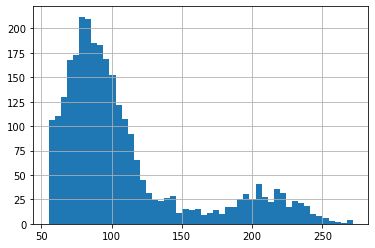

In [310]:
## cleaning avg_glucose_level var:
var = 'avg_glucose_level'

# Exploring missing values
pn(gdf_train[var].describe()) # count looks right
pn(gdf_test[var].describe()) # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # confirms checks for NAs
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # confirms checks for NAs 
# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at average glucose level distribution in sample
gdf_train[var].hist(bins=50) # interesting how there seems to be two probability peaks

count    2733.000000
mean       30.318697
std         7.257326
min        14.100000
25%        25.400000
50%        29.200000
75%        34.100000
max        92.000000
Name: bmi, dtype: float64 

Total Missings: 
 113 

count    693.000000
mean      30.177056
std        7.450611
min       11.500000
25%       24.900000
50%       28.700000
75%       34.400000
max       64.800000
Name: bmi, dtype: float64 

Total Missings: 
 27 

AxesSubplot(0.125,0.125;0.775x0.755)


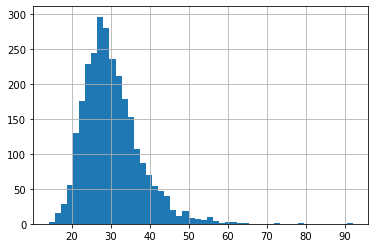

In [311]:
## cleaning bmi var:
var = 'bmi'

# Exploring mising values
pn(gdf_train[var].describe()) # some are missing
print('Total Missings: \n', sum(gdf_train[var].isnull()),'\n') # checks for number of NAs, about 3.9% of sample
pn(gdf_test[var].describe()) # some are missing
print('Total Missings: \n', sum(gdf_test[var].isnull()),'\n') # checks for number of NAs, about 3.8% of sample
# Because the missing values make up less than 5% of the samples, the nans will be removed

# Take a look at bmi distribution in sample
print(gdf_train[var].hist(bins=50))

count    2733.000000
mean       30.318697
std         7.257326
min        14.100000
25%        25.400000
50%        29.200000
75%        34.100000
max        92.000000
Name: bmi, dtype: float64 

Total Missings After Drop: 
 0 

count    693.000000
mean      30.177056
std        7.450611
min       11.500000
25%       24.900000
50%       28.700000
75%       34.400000
max       64.800000
Name: bmi, dtype: float64 

Total Missings After Drop: 
 0 

AxesSubplot(0.125,0.125;0.775x0.755)


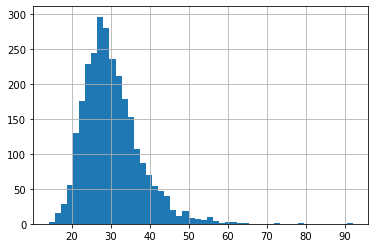

In [312]:
# Removing missing values
gdf_train= gdf_train.dropna(subset=[var])
pn(gdf_train[var].describe()) # looks like the stats did not change
print('Total Missings After Drop: \n', sum(gdf_train[var].isnull()),'\n') # checks to see if drop was successful
gdf_test= gdf_test.dropna(subset=[var])
pn(gdf_test[var].describe()) # looks like the stats did not change
print('Total Missings After Drop: \n', sum(gdf_test[var].isnull()),'\n') # checks to see if drop was successful

# Take a look at bmi distribution in sample
print(gdf_train[var].hist(bins=50)) # doesn't look like distribution was effected by droped observations

Training Set:
count    2733.000000
mean        0.061471
std         0.240236
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: heart_disease, dtype: float64
Total Missings: 
 0 

Test Set:
count    693.000000
mean       0.054834
std        0.227820
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: heart_disease, dtype: float64
Total Missings: 
 0 



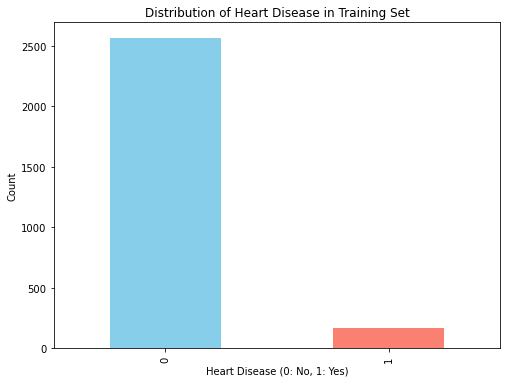

In [313]:
## cleaning heart_disease var:

var = 'heart_disease'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Heart Disease in Training Set')
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

Training Set:
count    2733.000000
mean        0.120015
std         0.325038
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: hypertension, dtype: float64
Total Missings: 
 0 

Test Set:
count    693.000000
mean       0.115440
std        0.319783
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: hypertension, dtype: float64
Total Missings: 
 0 



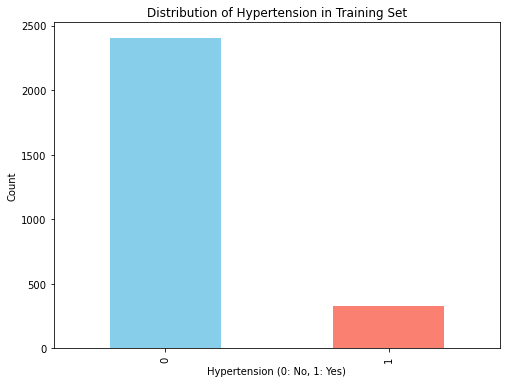

In [314]:
## cleaning hypertension var:

var = 'hypertension'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Hypertension in Training Set')
plt.xlabel('Hypertension (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

Training Set:
count       2733
unique         3
top       Female
freq        1666
Name: gender, dtype: object
Female    1666
Male      1066
Other        1
Name: gender, dtype: int64
Female    1666
Male      1066
Name: gender, dtype: int64
Total Missings: 
 0 

Test Set:
count        693
unique         2
top       Female
freq         420
Name: gender, dtype: object
Female    420
Male      273
Name: gender, dtype: int64
Total Missings: 
 0 



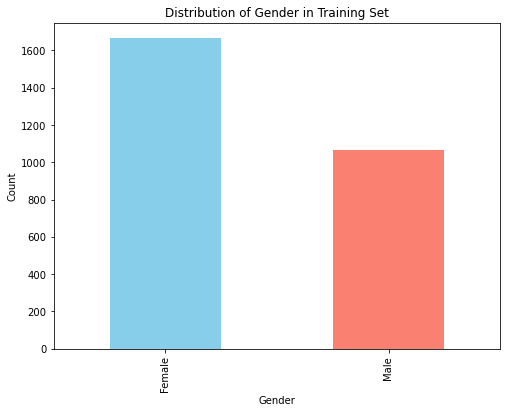

In [315]:
## cleaning gender var:

var = 'gender'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print(gdf_train[var].value_counts()) #need to remove other
gdf_train = gdf_train[gdf_train[var] != 'Other']
print(gdf_train[var].value_counts())

print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right, notice, there are onlu two unique values, so will have to manually enter Other in one hot encoding
print(gdf_test[var].value_counts())  # count looks right
gdf_test = gdf_test[gdf_test[var] != 'Other']

print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Gender in Training Set')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Training Set:
count     2732
unique       2
top        Yes
freq      2080
Name: ever_married, dtype: object
Total Missings: 
 0 

Test Set:
count     693
unique      2
top       Yes
freq      519
Name: ever_married, dtype: object
Total Missings: 
 0 



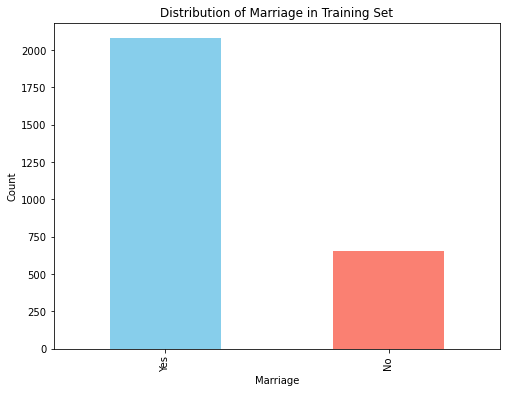

In [316]:
## cleaning ever_married var:

var = 'ever_married'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

# Take a look at the distribution of heart_disease
plt.figure(figsize=(8, 6))
gdf_train[var].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Marriage in Training Set')
plt.xlabel('Marriage')
plt.ylabel('Count')
plt.show()

In [317]:
## cleaning stroke var:

var = 'stroke'

# Exploring missing values
print('Training Set:')
print(gdf_train[var].describe())  # count looks right
print('Total Missings: \n', sum(gdf_train[var].isnull()), '\n')  # confirms checks for NAs

print('Test Set:')
print(gdf_test[var].describe())  # count looks right, notice
print('Total Missings: \n', sum(gdf_test[var].isnull()), '\n')  # confirms checks for NAs

# No nulls need to be removed, this finding is compatible with the value count listed in the describe() output above

Training Set:
count    2732.000000
mean        0.053807
std         0.225677
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64
Total Missings: 
 0 

Test Set:
count    693.000000
mean       0.047619
std        0.213113
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: stroke, dtype: float64
Total Missings: 
 0 



Cleaned dataframes

In [318]:
gdf_train.head()
gdf_train.describe()

,Unnamed: 0,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,2732.000000,2732.000000,2732.000000,2732.000000,2732.000000,2732.000000,2732.000000,2732.000000
mean,2551.144583,37128.839678,48.814056,0.120059,0.061493,108.223481,30.321596,0.053807
std,1493.150121,21091.091871,18.815623,0.325090,0.240277,47.543172,7.257072,0.225677
min,1.000000,84.000000,10.000000,0.000000,0.000000,55.120000,14.100000,0.000000
25%,1250.250000,18602.500000,34.000000,0.000000,0.000000,77.290000,25.400000,0.000000
50%,2544.000000,37865.500000,50.000000,0.000000,0.000000,92.795000,29.200000,0.000000
75%,3854.250000,55431.750000,63.000000,0.000000,0.000000,116.025000,34.100000,0.000000
max,5108.000000,72915.000000,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [319]:
gdf_test.head()
gdf_test.describe()

,Unnamed: 0,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,2490.581530,38140.388167,48.015873,0.115440,0.054834,108.659336,30.177056,0.047619
std,1469.651121,20885.760200,18.985271,0.319783,0.227820,48.379366,7.450611,0.213113
min,23.000000,239.000000,10.000000,0.000000,0.000000,55.250000,11.500000,0.000000
25%,1155.000000,20825.000000,32.000000,0.000000,0.000000,76.630000,24.900000,0.000000
50%,2520.000000,38796.000000,49.000000,0.000000,0.000000,91.020000,28.700000,0.000000
75%,3739.000000,55775.000000,62.000000,0.000000,0.000000,117.340000,34.400000,0.000000
max,5109.000000,72861.000000,82.000000,1.000000,1.000000,263.560000,64.800000,1.000000


Creating numerical dataframes using one hot encoding so a decision tree can be used

In [320]:
# mdf_train_y not defined:
# mdf_train_y.head()
# mdf_train_y.describe()

In [321]:
#trying to make the tree
#hot_encoded data
catDF_test = gdf_test[["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]]
catDF_train = gdf_train[["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]]


# Apply one-hot encoding to all categorical columns in catDF
ddf_test = pd.get_dummies(catDF_test, dtype='int')
ddf_train = pd.get_dummies(catDF_train, dtype='int')
ddf_train.head()

,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1,0,1,1,0,0,0,0,0,1,1,0,0
1,1,0,0,1,1,0,0,0,0,1,0,0,1,0
3,1,0,0,1,0,0,0,1,0,0,1,0,1,0
5,0,1,1,0,0,0,1,0,0,0,1,0,0,1
6,1,0,0,1,0,0,1,0,0,0,1,0,1,0


In [322]:
ddf_test.head()

,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1,0,1,0,0,1,0,0,0,1,0,1,0
2,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,1,0,0,1,0,0,0,1,0,0,1,0,1,0
6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
7,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [323]:
numDF_test = gdf_test[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']]
numDF_train = gdf_train[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']]


X_test = pd.concat([ddf_test, numDF_test], axis=1)  # Replace ddf_test with your actual dataframe
X_train = pd.concat([ddf_train, numDF_train], axis=1)  # Replace ddf_train with your actual dataframe

y_test = gdf_test['stroke']
y_train =gdf_train['stroke']


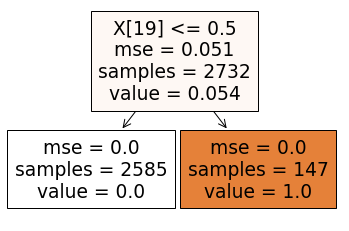

Coefficient of determination:  1.0
RMSE:  0.0


In [324]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

model = tree.DecisionTreeRegressor(max_depth=2) # Set up the tree
cart = model.fit(X_train, y_train) # Fit the tree
tree.plot_tree(cart,filled=True) # Visualize the tree
plt.show()


# Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test) # Run test data through model to get y predictions
N_test = len(y_test) # number of outputs
residuals_cart = y_test - y_hat_cart # difference between predicted and real values

# Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 ) # Sum of squared errors
MSE_cart = SSE_cart/N_test # Mean of sum of squarerd errors
RMSE_cart = (MSE_cart)**(1/2) # Root of mean of sum of squared errors
TSS = np.sum( (y_test - y_train.mean())**2 )
R2_cart = 1 - SSE_cart/TSS # Coefficient of determination
print('Coefficient of determination: ', R2_cart) # R squared measure
print('RMSE: ', RMSE_cart)


In [325]:
tab = pd.crosstab(y_test, y_hat_cart, rownames=['Actual'], colnames=['Predicted'])

acc = (tab.iloc[0, 0] + tab.iloc[1, 1]) / tab.values.sum()
print('Accuracy:', acc)
print('\nConfusion Matrix:')
pd.crosstab(y_test, y_hat_cart)

Accuracy: 1.0

Confusion Matrix:


col_0,0.0,1.0
stroke,,
0,660,0
1,0,33


In [326]:
# Regression model using decision tree regressor

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

# Assuming df_train_x contains features and mdf_train_y contains target variable
X_train, X_test, y_train, y_test = train_test_split(df_train_x, mdf_train_y, test_size=0.2, random_state=42)

# Initialize the decision tree regressor
regressor = DecisionTreeRegressor(random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.2f}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2:.2f}')


RMSE: 0.29
R^2: -1.00


In [328]:
 # linear regression

In [329]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
linear_regressor = LinearRegression()

# Train model
linear_regressor.fit(X_train, y_train)

# Predictions on test set
y_pred_linear = linear_regressor.predict(X_test)

# Calculate RMSE and R^2
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
print(f'RMSE: {rmse_linear:.2f}')
r2_linear = r2_score(y_test, y_pred_linear)
print(f'R^2: {r2_linear:.2f}')

RMSE: 0.20
R^2: 0.08


In [330]:
# KNeighborsRegressor

In [331]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize Regressor 
knn_model = KNeighborsRegressor(n_neighbors=10)  # can adjust the number of neighbors 

# Train the model
knn_model.fit(X_train, y_train.values.ravel())  # Note: ravel() is used to convert y_train to a 1D array

# Predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Calculate RMSE and R^2
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
print(f'RMSE: {rmse_knn:.2f}')
r2_knn = r2_score(y_test, y_pred_knn)
print(f'R^2: {r2_knn:.2f}')


RMSE: 0.20
R^2: 0.01


In [332]:
# combine Decision Tree Regressor with KNN linear model

In [333]:
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Initialize the Decision Tree Regressor and Linear Regression models
dt_model = DecisionTreeRegressor(max_depth=5)
linear_model = LinearRegression()

# Initialize the Voting Regressor with both models
voting_model = VotingRegressor(estimators=[('decision_tree', dt_model), ('linear_regression', linear_model)])

# Train model
voting_model.fit(X_train, y_train.values.ravel())  # Note: ravel() is used to convert y_train to a 1D array

# Predictions on test set
y_pred_voting = voting_model.predict(X_test)

# Calculate RMSE and R^2
rmse_voting = mean_squared_error(y_test, y_pred_voting, squared=False)
print(f'RMSE: {rmse_voting:.2f}')
r2_voting = r2_score(y_test, y_pred_voting)
print(f'R^2: {r2_voting:.2f}')


RMSE: 0.20
R^2: 0.08


In [334]:
#  Decision Tree Regressor with a KNN neighbors model

In [335]:
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize the Decision Tree Regressor and KNN Regressor models
dt_model = DecisionTreeRegressor(max_depth=5)
knn_model = KNeighborsRegressor(n_neighbors=10)  # You can adjust the number of neighbors (k)

# Initialize the Voting Regressor with both models
voting_model = VotingRegressor(estimators=[('decision_tree', dt_model), ('knn', knn_model)])

# Train the ensemble model
voting_model.fit(X_train, y_train.values.ravel())  # Note: ravel() is used to convert y_train to a 1D array

# Make predictions on the test set
y_pred_voting = voting_model.predict(X_test)

# Calculate RMSE for the ensemble model
rmse_voting = mean_squared_error(y_test, y_pred_voting, squared=False)
print(f'RMSE: {rmse_voting:.2f}')

# Calculate R-squared for the ensemble model
r2_voting = r2_score(y_test, y_pred_voting)
print(f'R^2: {r2_voting:.2f}')


RMSE: 0.20
R^2: 0.06


In [336]:
#other way....



In [337]:
import pandas as pd

vars_for_model = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi']

## Make df of numbers

# Split the data
mdf_train_x = gdf_train.loc[:, vars_for_model]
mdf_train_y_data = gdf_train.loc[:, ['id', 'stroke']]
mdf_train_y = pd.DataFrame(data=mdf_train_y_data, columns=['id', 'stroke'])
mdf_train_y = mdf_train_y.drop(columns=['id'])
mdf_train_y = mdf_train_y.reset_index(drop=True)

# One hot encoding for categorical variables using pd.get_dummies
X_bi = pd.get_dummies(mdf_train_x, columns=['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type'])

# Numerical variables dataframe
X_num = mdf_train_x.loc[:, ['age', 'avg_glucose_level', 'bmi']]

# Concatenate the dataframes
df_train_x = pd.concat([X_bi, X_num], axis=1)
df_train_x = df_train_x.reset_index(drop=True)

# View the new dataframe
print(df_train_x.head())
print(df_train_x.dtypes)


    age  avg_glucose_level   bmi  gender_Female  gender_Male  hypertension_0  \
0  36.0              65.87  32.2              0            1               1   
1  45.0              68.66  25.3              1            0               1   
2  61.0              69.88  27.1              1            0               1   
3  34.0             108.47  30.4              0            1               1   
4  78.0             227.16  41.7              1            0               0   

   hypertension_1  heart_disease_0  heart_disease_1  ever_married_No  ...  \
0               0                1                0                0  ...   
1               0                1                0                0  ...   
2               0                1                0                0  ...   
3               0                1                0                1  ...   
4               1                0                1                0  ...   

   work_type_Govt_job  work_type_Never_worked  work_type

In [338]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(df_train_x, mdf_train_y, test_size=0.2, random_state=42)

# Initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display additional metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       523
           1       0.21      0.33      0.26        24

    accuracy                           0.92       547
   macro avg       0.59      0.64      0.61       547
weighted avg       0.94      0.92      0.92       547



In [339]:
vars_for_model = ['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi']

## Make df of numbers

# Split the data
mdf_train_x = gdf_train.loc[:,vars_for_model]
mdf_train_y_data = gdf_train.loc[:,['id','stroke']]
mdf_train_y = pd.DataFrame(data=mdf_train_y_data, columns=['id','stroke'])
mdf_train_y = mdf_train_y.drop(columns=['id'])
mdf_train_y = mdf_train_y.reset_index(drop=True)

# One hot encoding for categorical variables
from sklearn.preprocessing import LabelBinarizer
one_hot_encoder = LabelBinarizer()

var = 'gender'
oh = one_hot_encoder.fit_transform(mdf_train_x[var]) # One-hot encode the categorical variables
names = one_hot_encoder.classes_ # Get names of the classes
gender_df = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables

var = 'hypertension'
oh = one_hot_encoder.fit_transform(mdf_train_x[var]) # One-hot encode the categorical variables
names = ['hypertension', 'no_hypertension']
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
hypertension_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables

var = 'heart_disease'
oh = one_hot_encoder.fit_transform(mdf_train_x[var]) # One-hot encode the categorical variables
names = ['heart_disease','no_heart_disease']
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
heart_disease_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables

var = 'ever_married'
oh = one_hot_encoder.fit_transform(mdf_train_x[var]) # One-hot encode the categorical variables
names = ['ever_married','not_ever_married']
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
ever_married_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables

var = 'work_type'
oh = one_hot_encoder.fit_transform(mdf_train_x[var]) # One-hot encode the categorical variables
names = one_hot_encoder.classes_ # Get names of the classes
work_type_df = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables

var = 'Residence_type'
oh = one_hot_encoder.fit_transform(mdf_train_x[var]) # One-hot encode the categorical variables
names = one_hot_encoder.classes_ # Get names of the classes
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
Residence_type_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables
# Concatenate the one hot encoded dataframes
X_bi = pd.concat([gender_df, hypertension_df, heart_disease_df, ever_married_df, work_type_df, Residence_type_df], axis=1)

# Numerical variables dataframe
X_num = mdf_train_x.loc[:,['age','avg_glucose_level','bmi']]

# Concatenate the dataframes
df_train_x = pd.concat([X_bi, X_num], axis=1)
df_train_x = df_train_x.reset_index(drop=True)

# View the new dataframe
df_train_x.head()
df_train_x.dtypes

ValueError: Shape of passed values is (2732, 1), indices imply (2732, 2)

Perform same manipulations to the test x variables so that the model can be used

In [340]:
## Make df of numbers

# Split the data
mdf_test_x = gdf_test.loc[:,vars_for_model]
mdf_test_y_data = gdf_test.loc[:,['id','stroke']]
mdf_test_y = pd.DataFrame(data=mdf_test_y_data, columns=['id','stroke'])
mdf_test_y = mdf_test_y.drop(columns=['id'])
mdf_test_y = mdf_test_y.reset_index(drop=True)

# One hot encoding for categorical variables
from sklearn.preprocessing import LabelBinarizer
one_hot_encoder = LabelBinarizer()

var = 'gender'
oh = one_hot_encoder.fit_transform(mdf_test_x[var]) # One-hot encode the categorical variables
names = ['Female', 'Male', 'Other']
oh2 = 1-oh
def merger (A,B,C): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        c=0
        temp=[a,b,c]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2,oh2)
gender_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables

var = 'hypertension'
oh = one_hot_encoder.fit_transform(mdf_test_x[var]) # One-hot encode the categorical variables
names = ['hypertension', 'no_hypertension']
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
hypertension_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables

var = 'heart_disease'
oh = one_hot_encoder.fit_transform(mdf_test_x[var]) # One-hot encode the categorical variables
names = ['heart_disease','no_heart_disease']
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
heart_disease_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables

var = 'ever_married'
oh = one_hot_encoder.fit_transform(mdf_test_x[var]) # One-hot encode the categorical variables
names = ['ever_married','not_ever_married']
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
ever_married_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables

var = 'work_type'
oh = one_hot_encoder.fit_transform(mdf_test_x[var]) # One-hot encode the categorical variables
names = one_hot_encoder.classes_ # Get names of the classes
work_type_df = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables

var = 'Residence_type'
oh = one_hot_encoder.fit_transform(mdf_test_x[var]) # One-hot encode the categorical variables
names = one_hot_encoder.classes_ # Get names of the classes
oh2 = 1-oh
def merger (A,B): # source: PyNEwbie response to https://stackoverflow.com/questions/22597966/is-there-a-way-to-merge-multiple-list-index-by-index
    answer = []
    for y in range (len(A)):
        a=int(A[y])
        b=int(B[y])
        temp=[a,b]
        answer.append(temp)
    return answer
ohfinial = merger(oh,oh2)
Residence_type_df = pd.DataFrame( data = ohfinial, 
                                    columns = names) # Create a new df for the encoded variables
# Concatenate the one hot encoded dataframes
X_bi_test = pd.concat([gender_df, hypertension_df, heart_disease_df, ever_married_df, work_type_df, Residence_type_df], axis=1)

# Numerical variables dataframe
X_num_test = mdf_test_x.loc[:,['age','avg_glucose_level','bmi']]

# Concatenate the dataframes
df_test_x = pd.concat([X_bi_test, X_num_test], axis=1)
df_test_x = df_test_x.reset_index(drop=True)

# View the new dataframe
df_test_x.head()
df_test_x.describe()

,Female,Male,Other,hypertension,no_hypertension,heart_disease,no_heart_disease,ever_married,not_ever_married,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,age,avg_glucose_level,bmi
count,693.000000,693.000000,693.0,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,0.393939,0.606061,0.0,0.115440,0.884560,0.054834,0.945166,0.748918,0.251082,0.139971,0.008658,0.660895,0.170274,0.020202,0.522367,0.477633,48.015873,108.659336,30.177056
std,0.488975,0.488975,0.0,0.319783,0.319783,0.227820,0.227820,0.433949,0.433949,0.347208,0.092712,0.473748,0.376145,0.140792,0.499860,0.499860,18.985271,48.379366,7.450611
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,55.250000,11.500000
25%,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,76.630000,24.900000
50%,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,49.000000,91.020000,28.700000
75%,1.000000,1.000000,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,62.000000,117.340000,34.400000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,82.000000,263.560000,64.800000


In [341]:
mdf_test_y.head()
mdf_test_y.dtypes

stroke    int64
dtype: object

Now we begin testing models.

In [342]:
from sklearn import tree 

# Variables
X_train = df_train_x
y_train = mdf_train_y
X_test = df_test_x
y_test = mdf_test_y

In [343]:
print(X_train.isnull().sum())  # Check for missing values in X_train
print(y_train.isnull().sum())  # Check for missing values in y_train


age                        0
avg_glucose_level          0
bmi                        0
gender_Female              0
gender_Male                0
hypertension_0             0
hypertension_1             0
heart_disease_0            0
heart_disease_1            0
ever_married_No            0
ever_married_Yes           0
work_type_Govt_job         0
work_type_Never_worked     0
work_type_Private          0
work_type_Self-employed    0
work_type_children         0
Residence_type_Rural       0
Residence_type_Urban       0
age                        0
avg_glucose_level          0
bmi                        0
dtype: int64
stroke    0
dtype: int64


In [344]:
# Example imputation using mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)


In [345]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (2732, 21)
y_train shape: (2732, 1)


In [346]:
# Check for duplicates in X_train
print("Number of duplicates in X_train:", X_train.duplicated().sum())

# Check for missing values in y_train
print("Number of missing values in y_train:", y_train.isnull().sum())


Number of duplicates in X_train: 0
Number of missing values in y_train: stroke    0
dtype: int64


In [347]:
# Example: Remove duplicates
# Example: Remove duplicates
#X_train = X_train.drop_duplicates()
#y_train = y_train.loc[X_train.index]


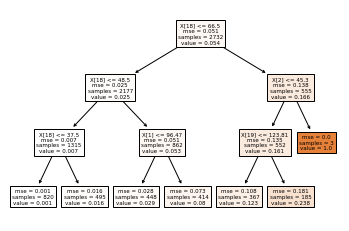

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [348]:
model = tree.DecisionTreeRegressor(max_depth=3) # Set up the tree
cart = model.fit(X_train, y_train) # Fit the tree
tree.plot_tree(cart,filled=True) # Visualize the tree
plt.show()

# Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test) # Run test data through model to get y predictions
N_test = len(y_test) # number of outputs
residuals_cart = y_test - y_hat_cart # difference between predicted and real values

# Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 ) # Sum of squared errors
MSE_cart = SSE_cart/N_test # Mean of sum of squarerd errors
RMSE_cart = (MSE_cart)**(1/2) # Root of mean of sum of squared errors
TSS = np.sum( (y_test - y_train.mean())**2 )
R2_cart = 1 - SSE_cart/TSS # Coefficient of determination
print('Coefficient of determination: ', R2_cart) # R squared measure
print('RMSE: ', RMSE_cart)

# BELOW THIS IS WHAT WAS ORIGINALLY IN THE FILE

In [349]:
y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())

In [350]:
## Linear Model
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#
dummies = pd.concat([ pd.get_dummies(X_train['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_train = pd.concat([continuous,dummies],axis=1)

X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

dummies = pd.concat([ pd.get_dummies(X_test['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_test = pd.concat([continuous,dummies],axis=1)

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
print('R2: ', reg.score(Z_test, y_test)) # R squared measure
y_hat = reg.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )   # R squared measure


AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names_out'

This is supposed to be fairly "fun," so please do not turn it into a combinatorial nightmare of comparing thousands of model specifications. Settle on a strategy you think is promising, crank it out, and write up the results. Your time and energy are valuable, so learn to recognize when the marginal cost of another twenty minutes on a project exceeds the benefit in terms of improving the results and your grade.
  
## Paper format

The format of the paper should be:

  - Summary: A one paragraph description of the question, methods, and results (about 350 words).
  - Data: One to two pages discussing the data and key variables, and any challenges in reading, cleaning, and preparing them for analysis.
  - Results: Two to five pages providing visualizations, statistics, a discussion of your methodology, and a presentation of your main findings. 
  - Conclusion: One to two pages summarizing the project, defending it from criticism, and suggesting additional work that was outside the scope of the project.
  - Appendix: If you have a significant number of additional plots or table that you feel are essential to the project, you can put any amount of extra content at the end and reference it from the body of the paper. 

## Submission

Half of each student's grade is based on their commits to the repo. Each student is expected to do something specific that contributes to the overall project outcome. Since commits are recorded explicitly by Git/GitHub, this is observable. A student can contribute by cleaning data, creating visualizations,performing analytic analyses,  or writing about results, but everyone has to do something substantial. A student's work doesn't need to make it into the final report to be valuable and substantial, and fulfill the requirement to make a contribution to the project. 

The other half of each student's grade is based on the written report. Groups will work together on combining results and writing up findings in a Jupyter noteb,ok, using code chunks to execute Python commands and markdown chunks to structure the paper and provide exposition. The notebook should run on Colab or Rivana from beginning to end without any errors.

mbers submit.

## Criteria

The project is graded based on four criteria:

  - Project Concept: What is the strategy for building and testing the group's models? How did the group decide how to use the tools presented so far in class? How did the group compare the performance of the options considered, and settle on a final choice for submission?
  - Wrangling, EDA, and Visualization: How are are missing values handled? For variables with large numbers of missing values, to what extent do the data and documentation provide an explanation for the missing data? If multiple data sources are used, how are the data merged? For the main variables in the analysis, are the relevant data summarized and visualized through a histogram or kernel density plot where appropriate? Are basic quantitative features of the data addressed and explained? How are outliers characterized and addressed? 
  - Analysis: What are the groups' main findings? Do the tables, plots, and statistics support the conclusions? Is the research strategy carried out correctly? If the research strategy succeeds, are the results interpreted correctly and appropriately? If the research strategy fails, is a useful discussion of the flaws of the data collection process or the research strategy discussed?
  - Replication/Documentation: Is the code appropriately commented? Can the main results be replicated from the code and original data files? Are significant choices noted and explained?

Each of the four criteria are equally weighted (25 points out of 100).